### **Variational Autoencoders (VAE)**

This notebook includes the training of a VAE on FashionMNIST dataset.      

Steps:       
1. Explore the FashionMNIST dataset    
2. Implement a custom sampling layer   
3. Implement encoder-decoder models using Functional APIs    
4. Implement the loss functions     
5. Train the VAE model     
6. Explore the results    



In [ ]:
# import the required libraries
import tensorflow as tf  
import os    
import random    
import numpy as np  

# GPU availability
print(f'Number of GPUs available :{len(tf.config.list_physical_devices("GPU"))}')


Number of GPUs available :1


In [ ]:
# Set seed
Seed = 42
os.environ['PYTHONHASSEED'] = str(Seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(Seed)
np.random.seed(Seed)
tf.random.set_seed(Seed)

### Exploring the FashionMNIST data set    
FashionMNIST is like the handwritten digits recognition MNIST dataset.             

Available classes:    
0 --> T-shirt/top     
1 --> Trouser     
2 --> Pullover          
3 --> Dress      
4 --> Coat      
5 --> Sandal     
6 --> Shirt    
7 --> Sneaker    
8 --> Bag   
9 --> Ankle boot

In [ ]:
# Load the data. Each image is 28x28, with 60000 training samples & 10000 test samples.
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Check its dimensions  
assert x_train.shape == (60000, 28, 28)
assert y_train.shape ==(60000,)
assert x_test.shape == (10000, 28, 28)
assert y_test.shape == (10000,)

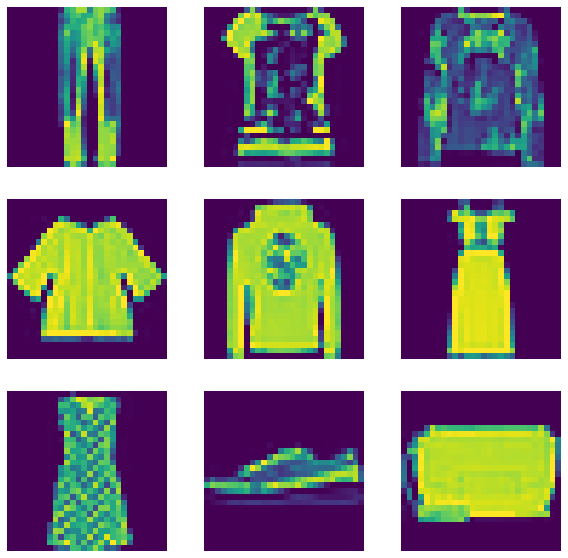

In [ ]:
#Let's look at the data
import matplotlib.pyplot as plt  
plt.figure(figsize=(10, 10))
#Choose 9 random samples from train data to see how it looks
rndsamples = np.random.choice(x_train.shape[0], 9)

for i in range(9):
  plt.subplot(3,3, i+1)
  plt.imshow(x_train[rndsamples[i]])
  plt.axis("off")

plt.show();

In [ ]:
# Concat train & test data for training VAE model
data = np.concatenate([x_train, x_test], axis=0)
# Reshape (CNN expects 3 channels) from 28X28 to 28X28X1 & Normalize the data
data = np.expand_dims(data, -1).astype('float32')/255

In [ ]:
data.shape

(70000, 28, 28, 1)

### Custom Sampling Layer

In [ ]:
from tensorflow.keras import layers  

# Creating a sampling layer   
class sampling_layer(layers.Layer):
  """Reparameterized Trick z = mu + sigma * epsilon """

  def call(self, inputs):
    zMean, zlogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]  
    epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
    return zMean + tf.exp(0.5 * zlogVar)*epsilon

In [ ]:
# Build encoder
def build_encoder(latentDim, encoderInputs):

  # Given a batch of images, the CNN block extract features 
  l1 = tf.keras.models.Sequential([
      layers.Conv2D(128, 3 , activation='relu', strides=2, padding='same'),
      layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
      layers.Flatten(),
      layers.Dense(256, activation='relu')
  ])

  # Pass the inputs to the convultion block
  x = l1(encoderInputs)

  # A dedicated layer to learn mean in parallel
  zMean = layers.Dense(latentDim, name='zMean')(x)

  # A dedicated layer to learn sigma in parallel
  zlogVar = layers.Dense(latentDim, name='zlogVar')(x)

  # Now use reparameterization trick to find z defined by mean & sigma
  z = sampling_layer()([zMean, zlogVar])

  # Model takes images as inputs & returns mean, sigma, & distribution
  return tf.keras.Model(encoderInputs, [zMean, zlogVar, z], name='encoder')

# Build the encoder
encoderInputs = tf.keras.Input(shape = (28,28,1))
encoder = build_encoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          878144      input_1[0][0]                    
__________________________________________________________________________________________________
zMean (Dense)                   (None, 2)            514         sequential[0][0]                 
__________________________________________________________________________________________________
zlogVar (Dense)                 (None, 2)            514         sequential[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Build Decoder model. Now we use Conv2DTranspose instead of Conv2D to generate images from lower dimensions to higher dimensions.

def build_decoder(latentInputs):
  #pass latentInputs to CNN block 
  l1 = tf.keras.models.Sequential([
    layers.Dense(7*7*64, activation='relu', input_shape = (latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3 , activation='relu', strides=2, padding='same'),
    layers.Conv2DTranspose(64,3, activation='relu', strides=2, padding='same'),
    layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
  ])
  return tf.keras.Model(latentInputs, l1(latentInputs), name='decoder')

# Build decoder
latentInputs = tf.keras.Input(shape = (2,))
decoder = build_decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         157633    
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


### Loss functions

VAE has 2 loss functions.     
**reconstruction loss** - It penalizes images that are not similar to the original images.     
**Kullback-Liebler (KL) Divergence** - It measure the distance between two probability distributions. It penalizes the model if it learns a probability distribution "z" that is different from the original distribution of data "X".    


In [ ]:
# Reconstruction loss
def reconstruction_loss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstructed),
      axis=(1,2)
      )
  )

# KL divergence loss
def kl_divergenceloss(zMean, zlogVar):
  return tf.reduce_mean(
      tf.reduce_sum(-0.5*(1 + zlogVar - tf.square(zMean) - tf.exp(zlogVar)), 
      axis=1
      )
  )

# Combine two losses
def calcTotalloss(data, reconstructed, zMean, zlogVar):
  loss1 = reconstruction_loss(data, reconstructed)
  loss2 = kl_divergenceloss(zMean, zlogVar)
  klweight = 3.0
  return loss1, loss2, loss1 + klweight*loss2

### Overriding train_step   
Since we are using a custom loss function on mu & sigma, we need to override how loss is calculated. We need to compare X_original & X_reconstructed at the same time while calculating the Kulback-Liebler (KL) loss.           

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # register total loss as an observable metric in the model training history
    self.totallossTracker = tf.keras.metrics.Mean(name = 'total_loss')
    self.celossTracker = tf.keras.metrics.Mean(name='ce_loss')
    self.kllossTracker = tf.keras.metrics.Mean(name='kl_loss')

  # These are all observable metrics
  @property
  def metrics(self):
    return [
            self.totallossTracker,
            self.celossTracker,
            self.kllossTracker
    ]

  # Calculate loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable weights 
    # that need to be updated
    with tf.GradientTape() as tape:
      # forward path
      zMean, zlogVar, z = self.encoder(data)
      reconstruction = self.decoder(z)
      celoss, klloss, totalloss = calcTotalloss(data, reconstruction, zMean, zlogVar)
    # backward path
    grads = tape.gradient(totalloss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss
    self.totallossTracker.update_state(totalloss)
    self.celossTracker.update_state(celoss)
    self.kllossTracker.update_state(klloss)

    # return the loss for history object
    return {
        'total_loss' : self.totallossTracker.result(),
        'ce_loss' : self.celossTracker.result(),
        'kl_loss' : self.kllossTracker.result()
    }

### Train the VAE model

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(data, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 24s 39ms/step - total_loss: 315.3279 - ce_loss: 304.4296 - kl_loss: 3.6328
Epoch 2/32
547/547 [==============================] - 21s 39ms/step - total_loss: 278.7410 - ce_loss: 265.0483 - kl_loss: 4.5643
Epoch 3/32
547/547 [==============================] - 21s 39ms/step - total_loss: 275.7191 - ce_loss: 261.5656 - kl_loss: 4.7178
Epoch 4/32
547/547 [==============================] - 21s 39ms/step - total_loss: 274.1810 - ce_loss: 259.7825 - kl_loss: 4.7994
Epoch 5/32
547/547 [==============================] - 21s 39ms/step - total_loss: 273.1335 - ce_loss: 258.5333 - kl_loss: 4.8667
Epoch 6/32
547/547 [==============================] - 21s 39ms/step - total_loss: 272.3083 - ce_loss: 257.6180 - kl_loss: 4.8968
Epoch 7/32
547/547 [==============================] - 21s 39ms/step - total_loss: 271.6022 - ce_loss: 256.7583 - kl_loss: 4.9480
Epoch 8/32
547/547 [==============================] - 21s 39ms/step - total_loss: 271.1787 - ce_l

Let's visualize how the loss functions are changing over each epoch.

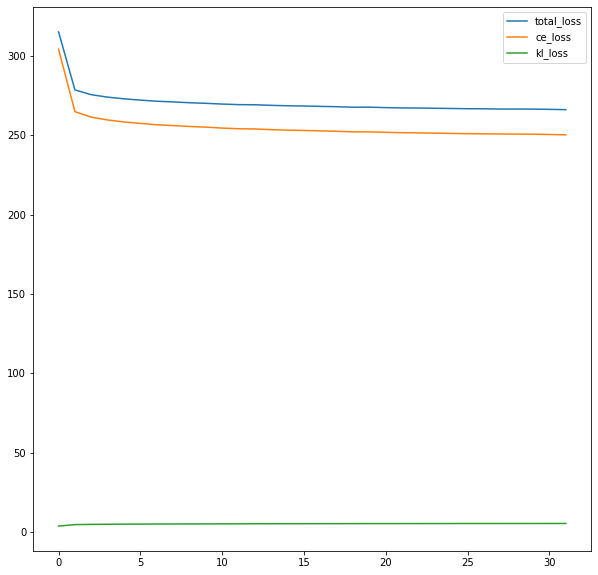

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history.get('total_loss'), label='total_loss')
plt.plot(history.history.get('ce_loss'), label='ce_loss')
plt.plot(history.history.get('kl_loss'), label='kl_loss')
plt.legend();

### Explore the results

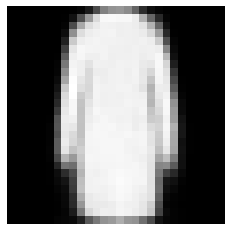

In [ ]:
#Let's use a mean (mu) of 1 & sigma of 2
res = vae.decoder.predict([[1,2]])
plt.axis('off')
plt.imshow(res.reshape(28,28), cmap='Greys_r')

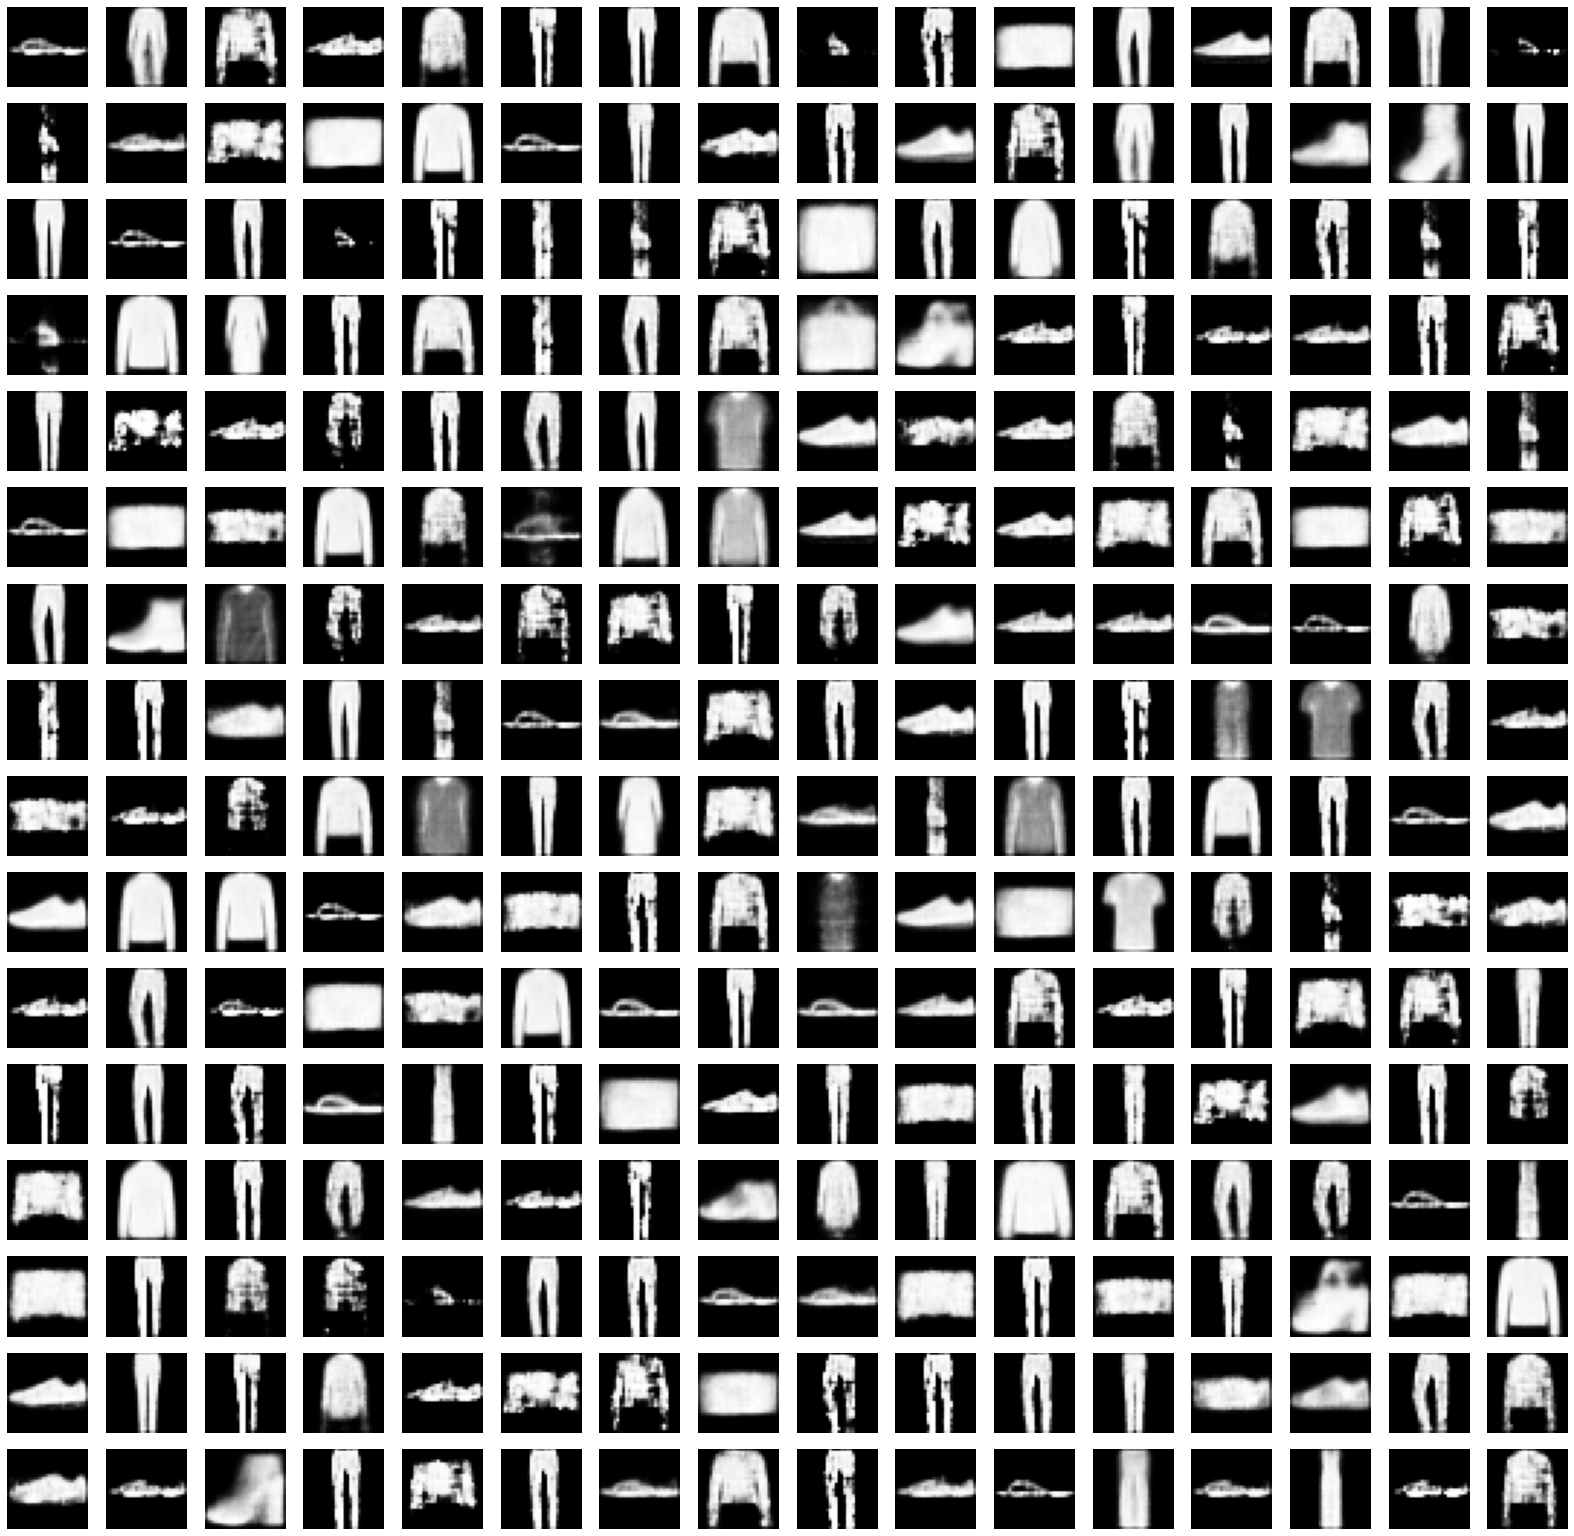

In [ ]:
# Let's generate 256 images entirely at random
z = np.random.normal(loc=0, scale=4, size=(256, 2))
res = vae.decoder.predict(z)
plt.figure(figsize=(28, 28))

for i in range(256):
  plt.subplot(16, 16, i+1)
  plt.imshow(res[i].reshape(28,28), cmap='Greys_r')
  plt.axis('off')

plt.show();


In [ ]:
#Let's take an image & generate its synthetic version
idx = 1240
batch = np.expand_dims(x_train[idx], 0)
batchofimages = np.expand_dims(batch, -1).astype('float32')/255 
# Get z (distribution) from give image
_,_,z = vae.encoder.predict(batchofimages)

# Now reconstruct the similar image
rec = vae.decoder.predict(z)


(-0.5, 27.5, 27.5, -0.5)

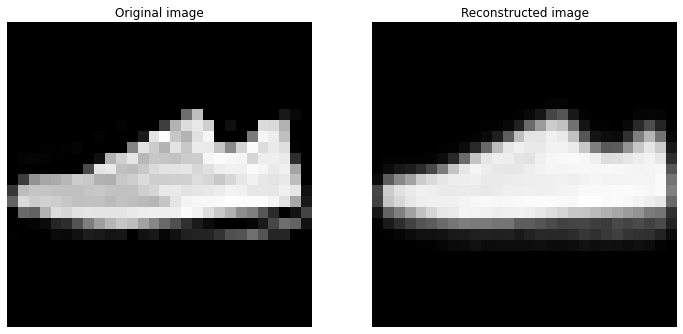

In [ ]:
plt.figure(figsize=(12,12))

# original image
plt.subplot(1, 2, 1)
plt.imshow(x_train[idx], cmap='Greys_r')
plt.title('Original image')
plt.axis('off')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.title('Reconstructed image')
plt.imshow(rec.reshape(28,28), cmap='Greys_r')
plt.axis('off')